**Predictive Modelling**

Importing libs and loding data

In [1]:
!pip install geopandas xgboost --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 58.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.1/16.1 MB 80.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 103.8 MB/s eta 0:00:00


In [2]:
import geopandas as gpd
import sklearn as sk
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error


In [3]:
df = gpd.read_file("/content/drive/MyDrive/lehd/NYC Area2010_2data.shp")

In [4]:
df.shape

(108487, 71)

In [5]:
df.columns

Index(['STATEFP10', 'COUNTYFP10', 'TRACTCE10', 'BLOCKCE10', 'GEOID10',
       'NAME10', 'MTFCC10', 'UR10', 'UACE10', 'UATYP10', 'FUNCSTAT10',
       'ALAND10', 'AWATER10', 'INTPTLAT10', 'INTPTLON10', 'GISJOIN',
       'Shape_area', 'Shape_len', 'C000_02', 'CE01_02', 'CE02_02', 'CE03_02',
       'C000_03', 'CE01_03', 'CE02_03', 'CE03_03', 'C000_04', 'CE01_04',
       'CE02_04', 'CE03_04', 'C000_05', 'CE01_05', 'CE02_05', 'CE03_05',
       'C000_06', 'CE01_06', 'CE02_06', 'CE03_06', 'C000_07', 'CE01_07',
       'CE02_07', 'CE03_07', 'C000_08', 'CE01_08', 'CE02_08', 'CE03_08',
       'C000_09', 'CE01_09', 'CE02_09', 'CE03_09', 'C000_10', 'CE01_10',
       'CE02_10', 'CE03_10', 'C000_11', 'CE01_11', 'CE02_11', 'CE03_11',
       'C000_12', 'CE01_12', 'CE02_12', 'CE03_12', 'C000_13', 'CE01_13',
       'CE02_13', 'CE03_13', 'C000_14', 'CE01_14', 'CE02_14', 'CE03_14',
       'geometry'],
      dtype='object')

**Variable Desription**


---

* STATEFP10	State FIPS code
* COUNTYFP10	County FIPS code
* TRACTCE10	Tract FIPS code
* BLOCKCE10	Block FIPS code
* GEOID10	Unique Geographic identifier (FIPS code)
* UR10	Urban (U) - rural (R) classification
* UACE10	Urban area census code
* UATYP10	Urban type area. U: Urbanized areas of 50,000 people or more. C: Urban Clusters (UCs) of at least 2,500 and less than 50,000 people.
* ALAND10	Land area
* AWATER10	Water area
* INTPTLAT10	Latitude
* INTPTLON10	Longitude
* Shape_area	Polygon area
* Shape_len	Polygon length
* C000_YR	Total number of jobs in year YR
* CE01_YR	Number of jobs with earnings $1250/month or less in year YR

* CE02_YR	Number of jobs with earnings $1251-3333/month in year YR

* CE03_YR	Number of jobs with earnings greater than $3333/month in year YR



**The predictive modelling part is divided into 4 parts. *Each part have a diffrent model*.**


---

1. Model 1 - Predict the total number of jobs in a given area (Target variable used C000_YR)

2. Model 2 - Predict the number of low-earning jobs (earnings of $1250/month or less) in a given area (Target variable used CE01_YR)

3. Model 3 - Predict the number of medium-earning jobs (earnings between $1251-3333/month) in a given area (Target variable used CE02_YR)

4. Model 4 - Predict the number of high-earning jobs (earnings greater than $3333/month) in a given area (Target variable used CE03_YR)


## **Model 1 - Predict the total number of jobs in a given area (Target variable used C000_YR)**

Based on ***'ALAND10', 'AWATER10', 'UR10', 'UATYP10', 'INTPTLAT10', 'INTPTLON10', 'Shape_area', 'Shape_len' and past 12 years of the total number of jobs*** we will predict the ***total number of jobs for the next year.***
* ALAND10 (Land area)
* AWATER10 (Water area)
* UR10 (Urban - rural classification)
* UATYP10 (Urban type area)
* INTPTLAT10 (Latitude)
* INTPTLON10 (Longitude)
* Shape_area (Polygon area)
* Shape_len (Polygon length)
* C000_YR (Total number of jobs in year YR)


In [6]:
past_12_years_columns = [(i<10 and f"C000_0{i}") or f"C000_{i}" for i in range(2,14)]
last_year = df[["C000_14"]] #13th year

In [7]:
past_12_years_columns

['C000_02',
 'C000_03',
 'C000_04',
 'C000_05',
 'C000_06',
 'C000_07',
 'C000_08',
 'C000_09',
 'C000_10',
 'C000_11',
 'C000_12',
 'C000_13']

In [8]:
X = df[['ALAND10', 'AWATER10', 'UR10', 'UATYP10', 'INTPTLAT10', 'INTPTLON10', 'Shape_area', 'Shape_len']+past_12_years_columns].convert_dtypes()

In [9]:
X.dtypes

ALAND10         Int64
AWATER10        Int64
UR10           string
UATYP10        string
INTPTLAT10     string
INTPTLON10     string
Shape_area    Float64
Shape_len     Float64
C000_02         Int64
C000_03         Int64
C000_04         Int64
C000_05         Int64
C000_06         Int64
C000_07         Int64
C000_08         Int64
C000_09         Int64
C000_10         Int64
C000_11         Int64
C000_12         Int64
C000_13         Int64
dtype: object

In [10]:
X[['UR10','UATYP10']] = X[['UR10','UATYP10']].fillna('missing_value')

In [11]:
X['INTPTLAT10'] = pd.to_numeric(X['INTPTLAT10'])
X['INTPTLON10'] = pd.to_numeric(X['INTPTLON10'])

# Encode categorical variables
le = LabelEncoder()
for column in ['UR10','UATYP10']:
    X[column] = le.fit_transform(X[column])

# Scale numeric features
scaler = StandardScaler()
numeric_columns = ['ALAND10', 'AWATER10', 'INTPTLAT10', 'INTPTLON10', 'Shape_area', 'Shape_len']
X[numeric_columns] = scaler.fit_transform(X[numeric_columns])

In [12]:
X.columns

Index(['ALAND10', 'AWATER10', 'UR10', 'UATYP10', 'INTPTLAT10', 'INTPTLON10',
       'Shape_area', 'Shape_len', 'C000_02', 'C000_03', 'C000_04', 'C000_05',
       'C000_06', 'C000_07', 'C000_08', 'C000_09', 'C000_10', 'C000_11',
       'C000_12', 'C000_13'],
      dtype='object')

In [13]:
y=last_year #this is the 13th year (target)

In [14]:
missing_values = y.isna().sum()
print(f"Number of missing values in the target variable: {missing_values}")


Number of missing values in the target variable: C000_14    0
dtype: int64


In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model1 = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
model1.fit(X_train, y_train)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=42, ...)

In [16]:
y_pred = model1.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")


Mean Squared Error: 367.02930954901353


Hence if a user is able to give 

---
Inputs - 
1. ALAND10 (Land area)
2.  AWATER10 (Water area)
3.  UR10 (Urban - rural classification)
4.  UATYP10 (Urban type area)
5.  INTPTLAT10 (Latitude)
6. INTPTLON10 (Longitude)
7. Shape_area (Polygon area)
8. Shape_len (Polygon length)
9. C000_YR (Total number of jobs in year YR) (12 years of data)


---


Output - 

They can predict the total number of jobs in that given area for the next year!



---



---



# **Model 2 - Predict the number of low-earning jobs (earnings of $1250/month or less) in a given area (Target variable used CE01_YR)**

Based on ***'ALAND10', 'AWATER10', 'UR10', 'UATYP10', 'INTPTLAT10', 'INTPTLON10', 'Shape_area', 'Shape_len' and past 12 years of the number of low-earning jobs*** we will predict the ***the number of low-earning jobs for next year***
* ALAND10 (Land area)
* AWATER10 (Water area)
* UR10 (Urban - rural classification)
* UATYP10 (Urban type area)
* INTPTLAT10 (Latitude)
* INTPTLON10 (Longitude)
* Shape_area (Polygon area)
* Shape_len (Polygon length)
* CE01_YR (the number of low-earning jobs YR)


In [17]:
past_12_years_columns = [(i<10 and f"CE01_0{i}") or f"CE01_{i}" for i in range(2,14)]
last_year = df[["CE01_14"]] #13th year

In [18]:
past_12_years_columns

['CE01_02',
 'CE01_03',
 'CE01_04',
 'CE01_05',
 'CE01_06',
 'CE01_07',
 'CE01_08',
 'CE01_09',
 'CE01_10',
 'CE01_11',
 'CE01_12',
 'CE01_13']

In [19]:
X = df[['ALAND10', 'AWATER10', 'UR10', 'UATYP10', 'INTPTLAT10', 'INTPTLON10', 'Shape_area', 'Shape_len']+past_12_years_columns].convert_dtypes()

In [20]:
X.dtypes

ALAND10         Int64
AWATER10        Int64
UR10           string
UATYP10        string
INTPTLAT10     string
INTPTLON10     string
Shape_area    Float64
Shape_len     Float64
CE01_02         Int64
CE01_03         Int64
CE01_04         Int64
CE01_05         Int64
CE01_06         Int64
CE01_07         Int64
CE01_08         Int64
CE01_09         Int64
CE01_10         Int64
CE01_11         Int64
CE01_12         Int64
CE01_13         Int64
dtype: object

In [21]:
X[['UR10','UATYP10']] = X[['UR10','UATYP10']].fillna('missing_value')

In [22]:
X['INTPTLAT10'] = pd.to_numeric(X['INTPTLAT10'])
X['INTPTLON10'] = pd.to_numeric(X['INTPTLON10'])

# Encode categorical variables
le = LabelEncoder()
for column in ['UR10','UATYP10']:
    X[column] = le.fit_transform(X[column])

# Scale numeric features
scaler = StandardScaler()
numeric_columns = ['ALAND10', 'AWATER10', 'INTPTLAT10', 'INTPTLON10', 'Shape_area', 'Shape_len']
X[numeric_columns] = scaler.fit_transform(X[numeric_columns])

In [23]:
X.columns

Index(['ALAND10', 'AWATER10', 'UR10', 'UATYP10', 'INTPTLAT10', 'INTPTLON10',
       'Shape_area', 'Shape_len', 'CE01_02', 'CE01_03', 'CE01_04', 'CE01_05',
       'CE01_06', 'CE01_07', 'CE01_08', 'CE01_09', 'CE01_10', 'CE01_11',
       'CE01_12', 'CE01_13'],
      dtype='object')

In [24]:
y=last_year #this is the 13th year (target)

In [25]:
missing_values = y.isna().sum()
print(f"Number of missing values in the target variable: {missing_values}")


Number of missing values in the target variable: CE01_14    0
dtype: int64


In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model2 = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
model2.fit(X_train, y_train)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=42, ...)

In [27]:
y_pred = model2.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")


Mean Squared Error: 37.70886593075932


Hence if a user is able to give 

---
Inputs - 
1. ALAND10 (Land area)
2.  AWATER10 (Water area)
3.  UR10 (Urban - rural classification)
4.  UATYP10 (Urban type area)
5.  INTPTLAT10 (Latitude)
6. INTPTLON10 (Longitude)
7. Shape_area (Polygon area)
8. Shape_len (Polygon length)
9. CE01_YR (the number of low-earning jobs YR) (12 years of data)


---


Output - 

They can predict the number of low-earning jobs in that given area for the next year!



---



---



# **Model 3 - Predict the number of medium-earning jobs (earnings between $1251-3333/month) in a given area (Target variable used CE02_YR)**

Based on ***'ALAND10', 'AWATER10', 'UR10', 'UATYP10', 'INTPTLAT10', 'INTPTLON10', 'Shape_area', 'Shape_len' and past 12 years of the number of medium-earning jobs*** we will predict the ***the number of medium-earning jobs for next year***
* ALAND10 (Land area)
* AWATER10 (Water area)
* UR10 (Urban - rural classification)
* UATYP10 (Urban type area)
* INTPTLAT10 (Latitude)
* INTPTLON10 (Longitude)
* Shape_area (Polygon area)
* Shape_len (Polygon length)
* CE02_YR (the number of medium-earning jobs YR)


In [28]:
past_12_years_columns = [(i<10 and f"CE02_0{i}") or f"CE02_{i}" for i in range(2,14)]
last_year = df[["CE02_14"]] #13th year

In [29]:
past_12_years_columns

['CE02_02',
 'CE02_03',
 'CE02_04',
 'CE02_05',
 'CE02_06',
 'CE02_07',
 'CE02_08',
 'CE02_09',
 'CE02_10',
 'CE02_11',
 'CE02_12',
 'CE02_13']

In [30]:
X = df[['ALAND10', 'AWATER10', 'UR10', 'UATYP10', 'INTPTLAT10', 'INTPTLON10', 'Shape_area', 'Shape_len']+past_12_years_columns].convert_dtypes()

In [31]:
X.dtypes

ALAND10         Int64
AWATER10        Int64
UR10           string
UATYP10        string
INTPTLAT10     string
INTPTLON10     string
Shape_area    Float64
Shape_len     Float64
CE02_02         Int64
CE02_03         Int64
CE02_04         Int64
CE02_05         Int64
CE02_06         Int64
CE02_07         Int64
CE02_08         Int64
CE02_09         Int64
CE02_10         Int64
CE02_11         Int64
CE02_12         Int64
CE02_13         Int64
dtype: object

In [32]:
X[['UR10','UATYP10']] = X[['UR10','UATYP10']].fillna('missing_value')

In [33]:
X['INTPTLAT10'] = pd.to_numeric(X['INTPTLAT10'])
X['INTPTLON10'] = pd.to_numeric(X['INTPTLON10'])

# Encode categorical variables
le = LabelEncoder()
for column in ['UR10','UATYP10']:
    X[column] = le.fit_transform(X[column])

# Scale numeric features
scaler = StandardScaler()
numeric_columns = ['ALAND10', 'AWATER10', 'INTPTLAT10', 'INTPTLON10', 'Shape_area', 'Shape_len']
X[numeric_columns] = scaler.fit_transform(X[numeric_columns])

In [34]:
X.columns

Index(['ALAND10', 'AWATER10', 'UR10', 'UATYP10', 'INTPTLAT10', 'INTPTLON10',
       'Shape_area', 'Shape_len', 'CE02_02', 'CE02_03', 'CE02_04', 'CE02_05',
       'CE02_06', 'CE02_07', 'CE02_08', 'CE02_09', 'CE02_10', 'CE02_11',
       'CE02_12', 'CE02_13'],
      dtype='object')

In [35]:
y=last_year #this is the 13th year (target)

In [36]:
missing_values = y.isna().sum()
print(f"Number of missing values in the target variable: {missing_values}")


Number of missing values in the target variable: CE02_14    0
dtype: int64


In [37]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model3 = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
model3.fit(X_train, y_train)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=42, ...)

In [38]:
y_pred = model3.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")


Mean Squared Error: 43.71148269699323


Hence if a user is able to give 

---
Inputs - 
1. ALAND10 (Land area)
2.  AWATER10 (Water area)
3.  UR10 (Urban - rural classification)
4.  UATYP10 (Urban type area)
5.  INTPTLAT10 (Latitude)
6. INTPTLON10 (Longitude)
7. Shape_area (Polygon area)
8. Shape_len (Polygon length)
9. CE02_YR (the number of medium-earning jobs YR) (12 years of data)


---


Output - 

They can predict the number of medium-earning jobs in that given area for the next year!



---



---



# **Model 4 - Predict the number of high-earning jobs (earnings greater than $3333/month) in a given area (Target variable used CE03_YR)**

Based on ***'ALAND10', 'AWATER10', 'UR10', 'UATYP10', 'INTPTLAT10', 'INTPTLON10', 'Shape_area', 'Shape_len' and past 12 years of the number of high-earning jobs*** we will predict the ***the number of high-earning jobs for next year***
* ALAND10 (Land area)
* AWATER10 (Water area)
* UR10 (Urban - rural classification)
* UATYP10 (Urban type area)
* INTPTLAT10 (Latitude)
* INTPTLON10 (Longitude)
* Shape_area (Polygon area)
* Shape_len (Polygon length)
* CE03_YR (the number of high-earning jobs YR)


In [39]:
past_12_years_columns = [(i<10 and f"CE03_0{i}") or f"CE03_{i}" for i in range(2,14)]
last_year = df[["CE03_14"]] #13th year

In [40]:
past_12_years_columns

['CE03_02',
 'CE03_03',
 'CE03_04',
 'CE03_05',
 'CE03_06',
 'CE03_07',
 'CE03_08',
 'CE03_09',
 'CE03_10',
 'CE03_11',
 'CE03_12',
 'CE03_13']

In [41]:
X = df[['ALAND10', 'AWATER10', 'UR10', 'UATYP10', 'INTPTLAT10', 'INTPTLON10', 'Shape_area', 'Shape_len']+past_12_years_columns].convert_dtypes()

In [42]:
X.dtypes

ALAND10         Int64
AWATER10        Int64
UR10           string
UATYP10        string
INTPTLAT10     string
INTPTLON10     string
Shape_area    Float64
Shape_len     Float64
CE03_02         Int64
CE03_03         Int64
CE03_04         Int64
CE03_05         Int64
CE03_06         Int64
CE03_07         Int64
CE03_08         Int64
CE03_09         Int64
CE03_10         Int64
CE03_11         Int64
CE03_12         Int64
CE03_13         Int64
dtype: object

In [43]:
X[['UR10','UATYP10']] = X[['UR10','UATYP10']].fillna('missing_value')

In [44]:
X['INTPTLAT10'] = pd.to_numeric(X['INTPTLAT10'])
X['INTPTLON10'] = pd.to_numeric(X['INTPTLON10'])

# Encode categorical variables
le = LabelEncoder()
for column in ['UR10','UATYP10']:
    X[column] = le.fit_transform(X[column])

# Scale numeric features
scaler = StandardScaler()
numeric_columns = ['ALAND10', 'AWATER10', 'INTPTLAT10', 'INTPTLON10', 'Shape_area', 'Shape_len']
X[numeric_columns] = scaler.fit_transform(X[numeric_columns])

In [45]:
X.columns

Index(['ALAND10', 'AWATER10', 'UR10', 'UATYP10', 'INTPTLAT10', 'INTPTLON10',
       'Shape_area', 'Shape_len', 'CE03_02', 'CE03_03', 'CE03_04', 'CE03_05',
       'CE03_06', 'CE03_07', 'CE03_08', 'CE03_09', 'CE03_10', 'CE03_11',
       'CE03_12', 'CE03_13'],
      dtype='object')

In [46]:
y=last_year #this is the 13th year (target)

In [47]:
missing_values = y.isna().sum()
print(f"Number of missing values in the target variable: {missing_values}")


Number of missing values in the target variable: CE03_14    0
dtype: int64


In [48]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model4 = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
model4.fit(X_train, y_train)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=42, ...)

In [49]:
y_pred = model4.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")


Mean Squared Error: 105.09684814659398


Predictions from Model 1 for Predicting the total number of jobs in all areas combined over a period of 20 years

Hence if a user is able to give 

---
Inputs - 
1. ALAND10 (Land area)
2.  AWATER10 (Water area)
3.  UR10 (Urban - rural classification)
4.  UATYP10 (Urban type area)
5.  INTPTLAT10 (Latitude)
6. INTPTLON10 (Longitude)
7. Shape_area (Polygon area)
8. Shape_len (Polygon length)
9. CE03_YR (the number of high-earning jobs YR) (12 years of data)


---


Output - 

They can predict the number of high-earning jobs in that given area for the next year!



---



---



# Predictions

Defining a preprocessing function which is common across all models

In [50]:
def preprocess(dataf,past_12_years_columns):
    X = dataf[['ALAND10', 'AWATER10', 'UR10', 'UATYP10', 'INTPTLAT10', 'INTPTLON10', 'Shape_area', 'Shape_len']+past_12_years_columns].convert_dtypes()
    X[['UR10','UATYP10']] = X[['UR10','UATYP10']].fillna('missing_value')
    X['INTPTLAT10'] = pd.to_numeric(X['INTPTLAT10'])
    X['INTPTLON10'] = pd.to_numeric(X['INTPTLON10'])

    # Encode categorical variables
    le = LabelEncoder()
    for column in ['UR10','UATYP10']:
        X[column] = le.fit_transform(X[column])

    # Scale numeric features
    scaler = StandardScaler()
    numeric_columns = ['ALAND10', 'AWATER10', 'INTPTLAT10', 'INTPTLON10', 'Shape_area', 'Shape_len']
    X[numeric_columns] = scaler.fit_transform(X[numeric_columns])

    return X

Defining a function for making predictions and returning next 3years of predictions

In [51]:
def predict_using_models(model,initial_X,all_year_column_names):
    data1 = initial_X
    past_data = []
    next_3 = []
    for i in range(3):
        pred = model.predict(data1)
        for i in range(len(all_year_column_names)):
            if i == len(all_year_column_names)-1:
                data1[all_year_column_names[i]]=pred
            else:
                data1[all_year_column_names[i]] = [data1[all_year_column_names[i+1]].iloc[0]]
        # print(data1[all_year_column_names[0]].iloc[0],data1[all_year_column_names[1]].iloc[0])
        next_3.append(pred[0])
    return next_3




---



---



***Note: Since there are many geographical Regions, we will be making predictions 
for only one geographical region.***

MODEL 1 PREDICTIONS ARE BELOW FOR GEOID 360050300004003 (Next 3 years)

Model 1 Predicts total number of jobs in a given area

In [52]:
model1_cols = [(i<10 and f"C000_0{i}") or f"C000_{i}" for i in range(2,14)]
print(model1_cols)

['C000_02', 'C000_03', 'C000_04', 'C000_05', 'C000_06', 'C000_07', 'C000_08', 'C000_09', 'C000_10', 'C000_11', 'C000_12', 'C000_13']


For purpose of predictions, we will be using GEOID10(Unique Geographic code) as 360050300004003.

In [53]:
unproc = df.loc[df['GEOID10']=="360050300004003"]
model1_data = preprocess(unproc,model1_cols)
model1_past = []
for i in range(len(model1_cols)):
    model1_past.append(model1_data[model1_cols[i]].iloc[0])
next_3_preds_model_1 = predict_using_models(model1,model1_data,model1_cols)
total_past_plus_next_3_model1 = model1_past+next_3_preds_model_1

In [54]:
next_3_preds_model_1

[98.59295, 100.94528, 101.450294]

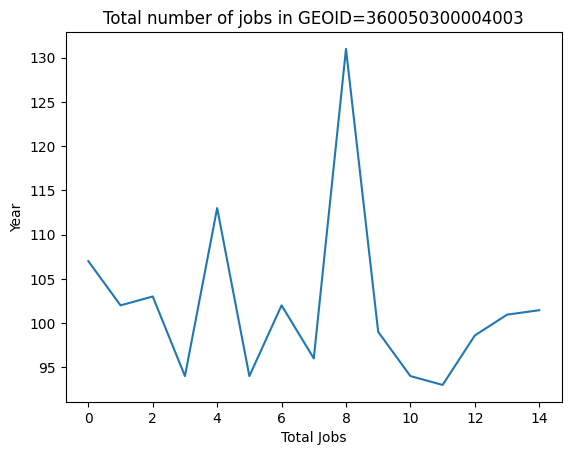

In [55]:
model_1_x = range(len(total_past_plus_next_3_model1))
model_1_y = total_past_plus_next_3_model1
plt.plot(model_1_x, model_1_y)
plt.title('Total number of jobs in GEOID=360050300004003')
plt.xlabel('Total Jobs')
plt.ylabel('Year')
plt.show()


Analysis from the Predictions of Model 1

The observed dip in total jobs in the region (GEOID=360050300004003) may have been due to economic downturns, changes in industries present in the area, or other external factors. The recovery, although at a decreasing rate, may indicate that the region is gradually stabilizing, but growth is slowing down.





---



---



---



---



MODEL 2 PREDICTIONS ARE BELOW FOR GEOID 360050300004003 (Next 3 years)

Model 2 Predicts total number of low-earning jobs in a given area

In [56]:
model2_cols = [(i<10 and f"CE01_0{i}") or f"CE01_{i}" for i in range(2,14)]
print(model2_cols)

['CE01_02', 'CE01_03', 'CE01_04', 'CE01_05', 'CE01_06', 'CE01_07', 'CE01_08', 'CE01_09', 'CE01_10', 'CE01_11', 'CE01_12', 'CE01_13']


For purpose of predictions, we will be using GEOID10(Unique Geographic code) as 360050300004003.

In [57]:
unproc = df.loc[df['GEOID10']=="360050300004003"]
model2_data = preprocess(unproc,model2_cols)
model2_past = []
for i in range(len(model2_cols)):
    model2_past.append(model2_data[model2_cols[i]].iloc[0])
next_3_preds_model_2 = predict_using_models(model2,model2_data,model2_cols)
total_past_plus_next_3_model2 = model2_past+next_3_preds_model_2

In [58]:
next_3_preds_model_2

[20.22889, 20.188272, 21.056166]

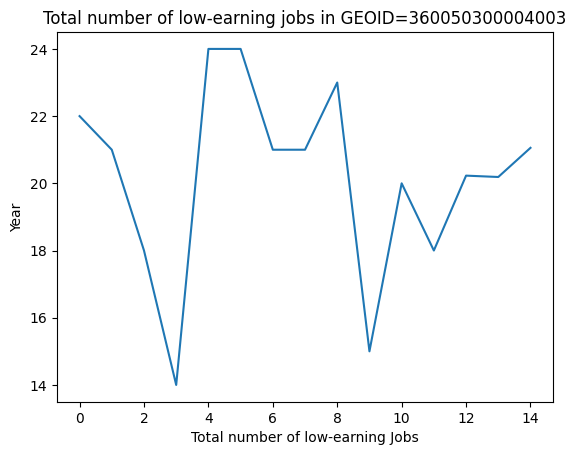

In [59]:
model_2_x = range(len(total_past_plus_next_3_model2))
model_2_y = total_past_plus_next_3_model2
plt.plot(model_2_x, model_2_y)
plt.title('Total number of low-earning jobs in GEOID=360050300004003')
plt.xlabel('Total number of low-earning Jobs')
plt.ylabel('Year')
plt.show()


Analysis from the Predictions of Model 2

The rapid recovery in the number of low-earning jobs could be driven by the expansion of industries that typically offer lower-paying jobs, such as retail or service sectors. Alternatively, it could also reflect that people are accepting lower-paying jobs due to a lack of better opportunities.




---



---



---



---



MODEL 3 PREDICTIONS ARE BELOW FOR GEOID 360050300004003 (Next 3 years)

Model 3 Predicts total number of medium-earning jobs in a given area

In [60]:
model3_cols = [(i<10 and f"CE02_0{i}") or f"CE02_{i}" for i in range(2,14)]
print(model3_cols)

['CE02_02', 'CE02_03', 'CE02_04', 'CE02_05', 'CE02_06', 'CE02_07', 'CE02_08', 'CE02_09', 'CE02_10', 'CE02_11', 'CE02_12', 'CE02_13']


For purpose of predictions, we will be using GEOID10(Unique Geographic code) as 360050300004003.

In [61]:
unproc = df.loc[df['GEOID10']=="360050300004003"]
model3_data = preprocess(unproc,model3_cols)
model3_past = []
for i in range(len(model3_cols)):
    model3_past.append(model3_data[model3_cols[i]].iloc[0])
next_3_preds_model_3 = predict_using_models(model3,model3_data,model3_cols)
total_past_plus_next_3_model3 = model3_past+next_3_preds_model_3

In [62]:
next_3_preds_model_3

[30.450678, 29.341873, 29.454325]

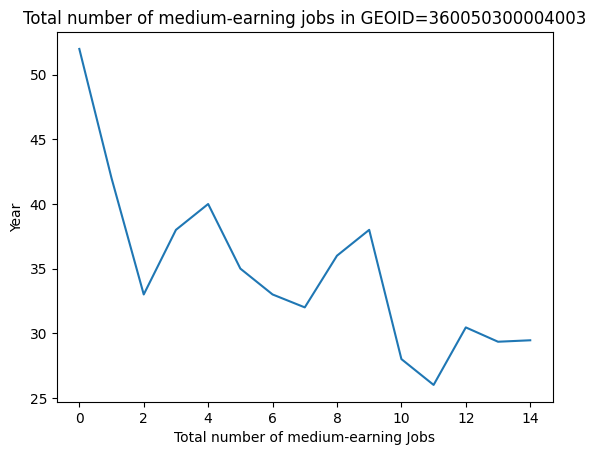

In [63]:
model_3_x = range(len(total_past_plus_next_3_model3))
model_3_y = total_past_plus_next_3_model3
plt.plot(model_3_x, model_3_y)
plt.title('Total number of medium-earning jobs in GEOID=360050300004003')
plt.xlabel('Total number of medium-earning Jobs')
plt.ylabel('Year')
plt.show()


Analysis from the Predictions of Model 3

The continuous decline in medium-earning jobs over the past 14 years may suggest a shift in the region's economy, with jobs moving to either the low-earning or high-earning categories. This trend might be indicative of growing income inequality, with middle-class jobs being replaced by lower-paying jobs or highly specialized, high-paying jobs.





---



---



---



---



MODEL 4 PREDICTIONS ARE BELOW FOR GEOID 360050300004003 (Next 3 years)

Model 4 Predicts total number of high-earning jobs in a given area

In [64]:
model4_cols = [(i<10 and f"CE03_0{i}") or f"CE03_{i}" for i in range(2,14)]
print(model4_cols)

['CE03_02', 'CE03_03', 'CE03_04', 'CE03_05', 'CE03_06', 'CE03_07', 'CE03_08', 'CE03_09', 'CE03_10', 'CE03_11', 'CE03_12', 'CE03_13']


For purpose of predictions, we will be using GEOID10(Unique Geographic code) as 360050300004003.

In [65]:
unproc = df.loc[df['GEOID10']=="360050300004003"]
model4_data = preprocess(unproc,model4_cols)
model4_past = []
for i in range(len(model4_cols)):
    model4_past.append(model4_data[model4_cols[i]].iloc[0])
next_3_preds_model_4 = predict_using_models(model4,model4_data,model4_cols)
total_past_plus_next_3_model4 = model4_past+next_3_preds_model_4

In [66]:
next_3_preds_model_4

[50.833633, 50.89897, 52.725636]

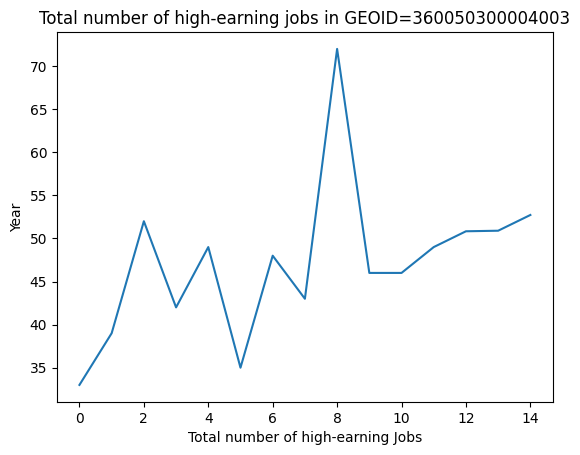

In [67]:
model_4_x = range(len(total_past_plus_next_3_model4))
model_4_y = total_past_plus_next_3_model4
plt.plot(model_4_x, model_4_y)
plt.title('Total number of high-earning jobs in GEOID=360050300004003')
plt.xlabel('Total number of high-earning Jobs')
plt.ylabel('Year')
plt.show()


Analysis from the Predictions of Model 4

The steady increase in high-earning jobs could be a result of the growth of specific industries or sectors in the region, such as technology, finance, or healthcare. This trend might be contributing to the decline in medium-earning jobs, as more specialized and highly skilled positions are created.

# **Conclusion (Usecase)**

*Predicting the number of jobs in different categories (total, low-earning, medium-earning, and high-earning) in a given area can have various financial use cases:*

1. **Economic development**: Understanding the distribution of jobs and their earnings can help local governments and organizations develop strategies to attract new businesses and investments, promoting economic growth in the area.

2. **Real estate market analysis**: Predicting job growth and the distribution of earnings can help real estate developers, investors, and agents make informed decisions about property investments, pricing, and marketing. Areas with a higher number of high-earning jobs may see increased demand for luxury housing, while areas with more low-earning jobs may have higher demand for affordable housing.

3. **Workforce development**: Predicting the number and types of jobs in an area can help educational institutions, training centers, and workforce development agencies to tailor their programs and resources to meet the needs of the local job market. For example, if there is a high demand for medium-earning jobs in a specific field, training centers can develop targeted programs to help individuals gain the necessary skills for those jobs.

4. **Infrastructure planning**: Predicting job growth can inform city planners and transportation agencies as they design and invest in public infrastructure, such as roads, public transportation, and utility services. Understanding the distribution of jobs and their earnings can help them prioritize projects based on areas with the greatest need.

5. **Financial services**: Banks, credit unions, and other financial institutions can use job distribution predictions to evaluate the creditworthiness of potential borrowers in a given area, as well as to identify opportunities for offering new financial products and services.



---

End of Predictive Modelling

---




